In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import tensorflow as tf
# import sumo as sm
import os
from traffic_initialization import *
import sys
from bs4 import BeautifulSoup
import tqdm
import pandas as pd

# New handy interface is here!
# Check interface.py for possible parameters
from interface import Simulation
%env SUMO_HOME=/usr/share/sumo
from datetime import datetime
%load_ext autotime

import concurrent.futures
from Some_models import OptimalDist
from Some_models import Throughput_nn

2024-04-27 02:43:38.917673: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 02:43:38.917895: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 02:43:38.919538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 02:43:38.939512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 02:43:39.318696: W tensorflow/compiler/tf2tensorrt/utils/py_uti

env: SUMO_HOME=/usr/share/sumo
time: 226 ms (started: 2024-04-27 02:43:39 +03:00)


In [2]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()

def throughput(N, d0, d1, d2, d3=2, default_gap=3, N_ave=12):
    
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

time: 451 µs (started: 2024-04-27 02:43:39 +03:00)


# Evidance of effect existence

Бытовой опыт и подсказывает нам, что при соблюдении некоторой дистанции на дороге, пробки рассасываются быстрее, однако простого изменения дистанции недостаточно. Например, при изменении фиксированного на всей трассе гэпа моделирование дает тривиальный результат: чем меньше расстояние между машинами - тем больше скорость потока.

In [5]:
X = np.linspace(0, 20, 10)
Y = np.zeros((X.shape))

for i in tqdm.tqdm(range(X.shape[0])):
    Y[i], _ = throughput(N=100, d0=X[i], d1=X[i], d2=X[i], d3=X[i], default_gap=X[i], N_ave=8)

100%|██████████| 10/10 [00:00<00:00, 17.36it/s]

time: 578 ms (started: 2024-04-27 01:03:09 +03:00)


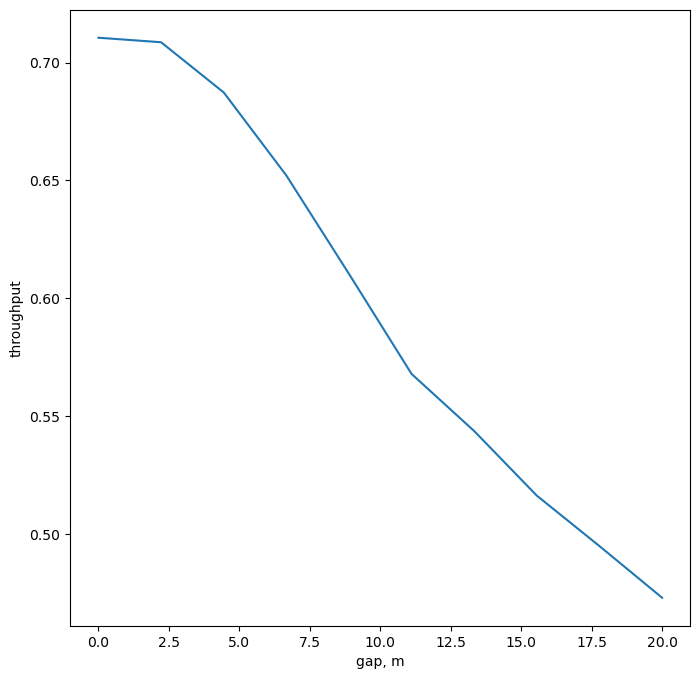

time: 87.7 ms (started: 2024-04-27 01:03:10 +03:00)


In [6]:
plt.subplots(figsize=(8, 8))
plt.plot(X, Y)
plt.xlabel('gap, m')
plt.ylabel('throughput')
plt.show()

Однако, если увеличить растояние на между машинами на линиях, заканчивающихся тупиком, можно получить существенный выигрыш в пропускной способности участка.

In [7]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test1', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=4)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 575.0 sec
time: 131 ms (started: 2024-04-27 00:01:03 +03:00)


In [8]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test2', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=20)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 455.0 sec
time: 94.6 ms (started: 2024-04-27 00:01:04 +03:00)


In [ ]:
X = np.linspace(0, 20, 20)
Y = np.linspace(0, 20, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=5000, d0=X[i], d1=X[i], d2=Y[j], d3=Y[j], default_gap=Y[j], N_ave=8)
np.savez('res_data/pres_graph', X=X,Y=Y, Z=Z)

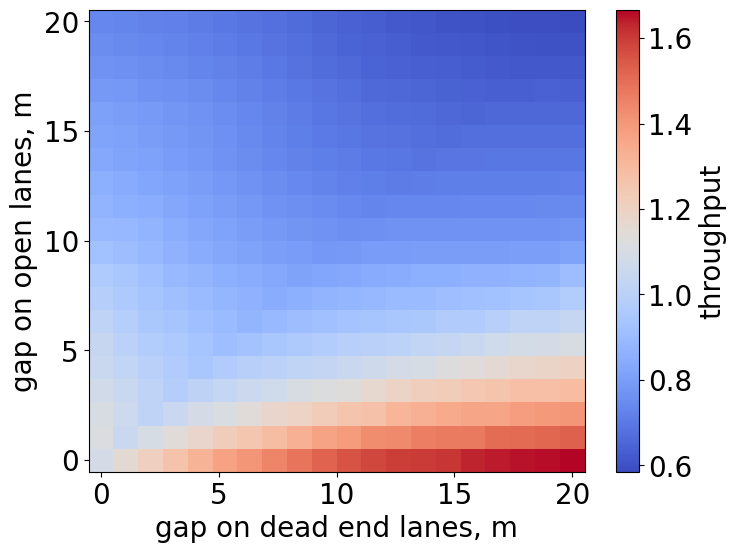

time: 71.3 ms (started: 2024-04-27 06:18:39 +03:00)


In [129]:
dict_ = np.load('res_data/pres_graph.npz')
X = dict_['X']
Y = dict_['Y']
Z = dict_['Z']

fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 6))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'gap on open lanes, m'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()
np.savez('res_data/pres_graph', X=X,Y=Y, Z=Z)

In [ ]:
X = np.linspace(0, 40, 20)
Y = np.linspace(1000, 5000, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=Y[j], d0=X[i], d1=X[i], d2=3, d3=3, default_gap=3, N_ave=8)
np.savez('res_data/pres_graph2', X=X,Y=Y, Z=Z)

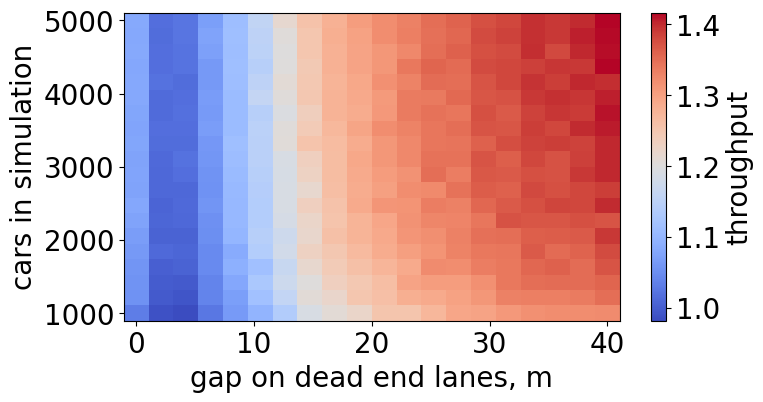

time: 52.3 ms (started: 2024-04-27 06:18:13 +03:00)


In [126]:
dict_ = np.load('res_data/pres_graph2.npz')
X = dict_['X']
Y = dict_['Y']
Z = dict_['Z']

fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 4))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'cars in simulation'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()

# Simple traffic without gap optimization

In [ ]:
# calculation of throughput()
N_arr=np.linspace(4000, 6000, 200)
out=np.zeros((200, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 2, 2, 2, default_gap=2)
    
np.savez('res_data/simple_throughput_wide', out=out, N_arr=N_arr)

<function matplotlib.pyplot.show(close=None, block=None)>

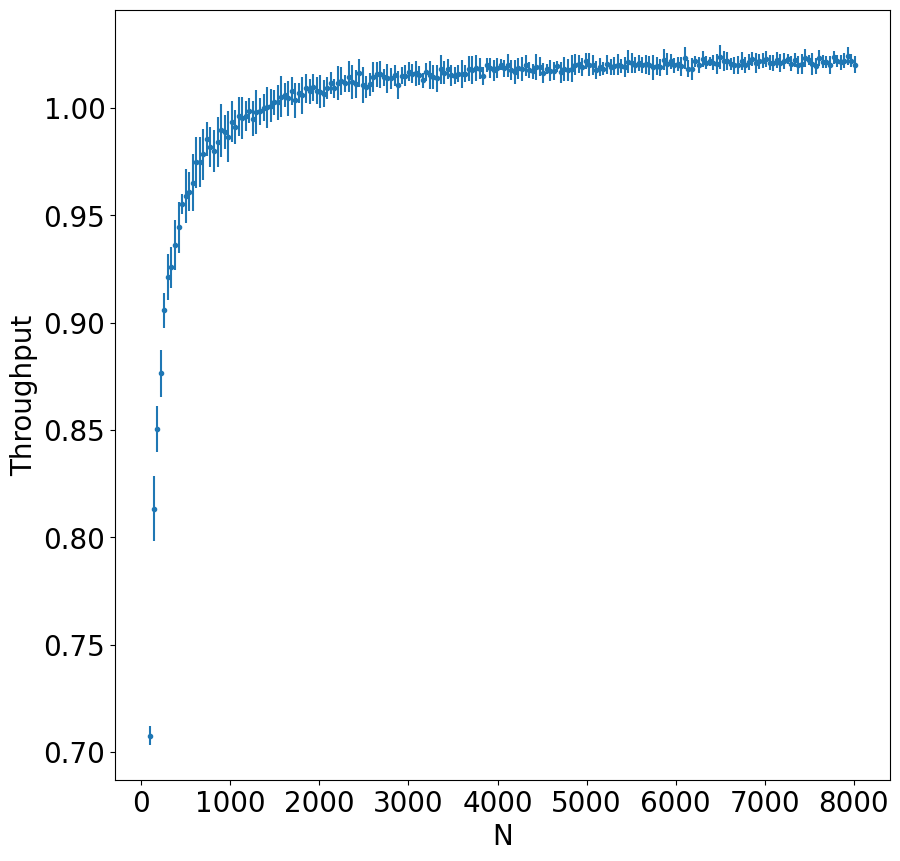

time: 80.9 ms (started: 2024-04-27 04:36:12 +03:00)


In [91]:
data = np.load('res_data/simple_throughput_wide.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'][50:250], data['out'][50:250, 0], yerr=np.asarray(data['out'][50:250, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

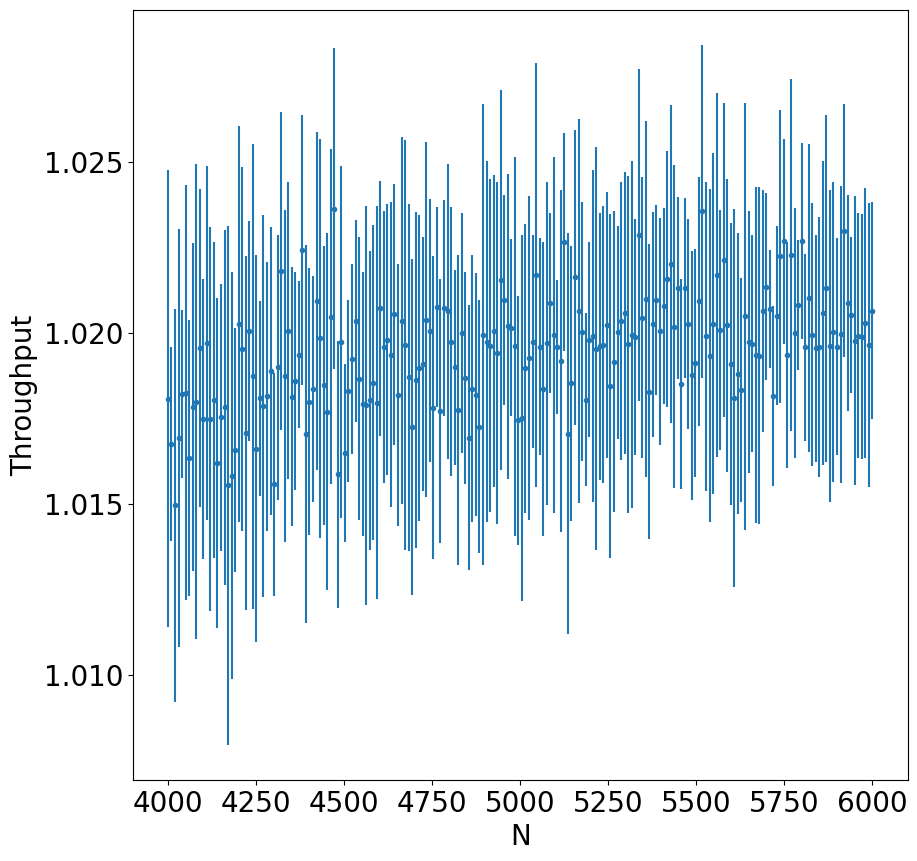

time: 80 ms (started: 2024-04-25 23:22:50 +03:00)


In [36]:
data = np.load('res_data/simple_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# Optimization with annealing

In [7]:
def loss(d, N):

    mean, _ = throughput(N=N, d0=d[0], d1=d[0], d2=d[1], N_ave=12)

    filename='csv_data/test6_mean.csv'
    csv_data = pd.read_csv(filename)
    csv_data.loc[len(csv_data)] = (d[0], d[0], d[1], N, mean)
    csv_data.to_csv(filename, index=False) 
    
    return -mean

time: 273 µs (started: 2024-04-27 01:03:32 +03:00)


In [84]:
# simple optimization

N_arr = np.zeros(1)
opt_d = np.zeros((1, 2))
opt_throughput = np.zeros(1)

for n in tqdm.tqdm(range(1)):

    N = 4000 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    opt_throughput[n] = -sol.fun
    
    np.savez('res_data/annealing_res', opt_d=opt_d, N_arr=N_arr)


100%|██████████| 1/1 [09:11<00:00, 551.23s/it]

time: 9min 11s (started: 2024-04-25 21:25:33 +03:00)


In [8]:
# dots for graph calc
data = np.load('res_data/annealing_res.npz')

opt_d = data['opt_d']
N_arr = data['N_arr']

time: 1.34 ms (started: 2024-04-27 01:03:59 +03:00)


In [118]:
out=np.zeros((N_arr.shape[0], 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], opt_d[n, 0], opt_d[n, 0], opt_d[n, 1])
    
np.savez('res_data/annealing_throughput', out=out, N_arr=N_arr)

100%|██████████| 13/13 [00:51<00:00,  3.95s/it]

time: 51.4 s (started: 2024-04-25 21:54:02 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

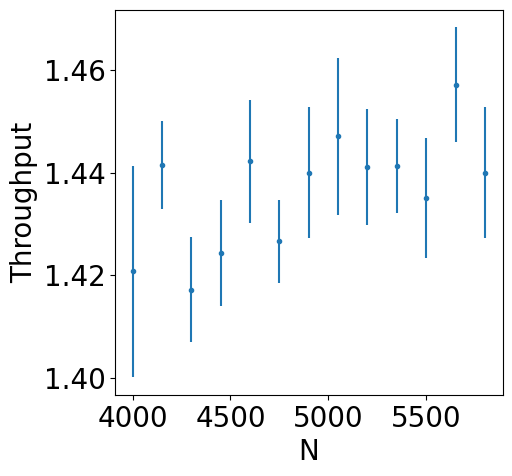

time: 54.9 ms (started: 2024-04-25 23:17:55 +03:00)


In [18]:
data=np.load('res_data/annealing_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# ML на основе бустинга
Тут есть два датасета:
    первый - состоит из значений troughput, посчитанных в случайных точках;
    второй - оптимизированный датасет, полученный из первого путем максимимзации значения throoughput

Далее обучаемся на каждом датасете и строим график для сравнения

In [21]:
dataName = 'csv_data/test6_without.csv'

raw_data = pd.read_csv(dataName)
print(raw_data.shape)
max_troughoutput_data = raw_data.loc[raw_data.groupby('N')['throughput'].idxmax()].reset_index(drop=True)
max_troughoutput_data.to_csv('csv_data/test6_without_cleaned.csv', index=False)
max_troughoutput_data.shape

(76373, 5)


(2001, 5)

time: 75.9 ms (started: 2024-04-27 01:09:37 +03:00)


In [12]:
obj = OptimalDist()
obj.fit_data('csv_data/test6_without_cleaned.csv', n_estimators=100, max_depth=3, seed=9)

MSE на обучающих данных: 36.825925355953274
MSE на тестовых данных: 69.89263426009713
time: 44.4 ms (started: 2024-04-27 03:08:05 +03:00)


In [44]:
# bad_data_filename = 'csv_data/test6_mean_combined.csv'
bad_data_filename = 'csv_data/test6_without.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

# good_data_filename = 'csv_data/test6_cleaned.csv'
good_data_filename = 'csv_data/test6_without_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

data_filenames = [bad_data_filename, good_data_filename]
res_filenames = [bad_res_filename, good_res_filename]

obj = OptimalDist()

for i in range(len(data_filenames)):
    obj.fit_data(data_filenames[i])
    inflow = np.linspace(4000, 6000, 31)
    outflow = np.zeros((len(inflow), 2))

    for j in tqdm.tqdm(range(len(inflow))):
    # for j, n in enumerate(inflow):
        d0, d1, d2 = obj.predict(inflow[j])[0]
        outflow[j, :] = throughput(d0=d0, d1=d1, d2=d2, N=inflow[j])
    np.savez(res_filenames[i], N_arr=inflow, out=outflow)

MSE на обучающих данных: 102.79189342916679
MSE на тестовых данных: 105.16850444046578


100%|██████████| 31/31 [01:01<00:00,  1.98s/it]


MSE на обучающих данных: 37.14327457699259
MSE на тестовых данных: 72.77229264038655


100%|██████████| 31/31 [00:58<00:00,  1.90s/it]

time: 2min 1s (started: 2024-04-27 04:14:02 +03:00)


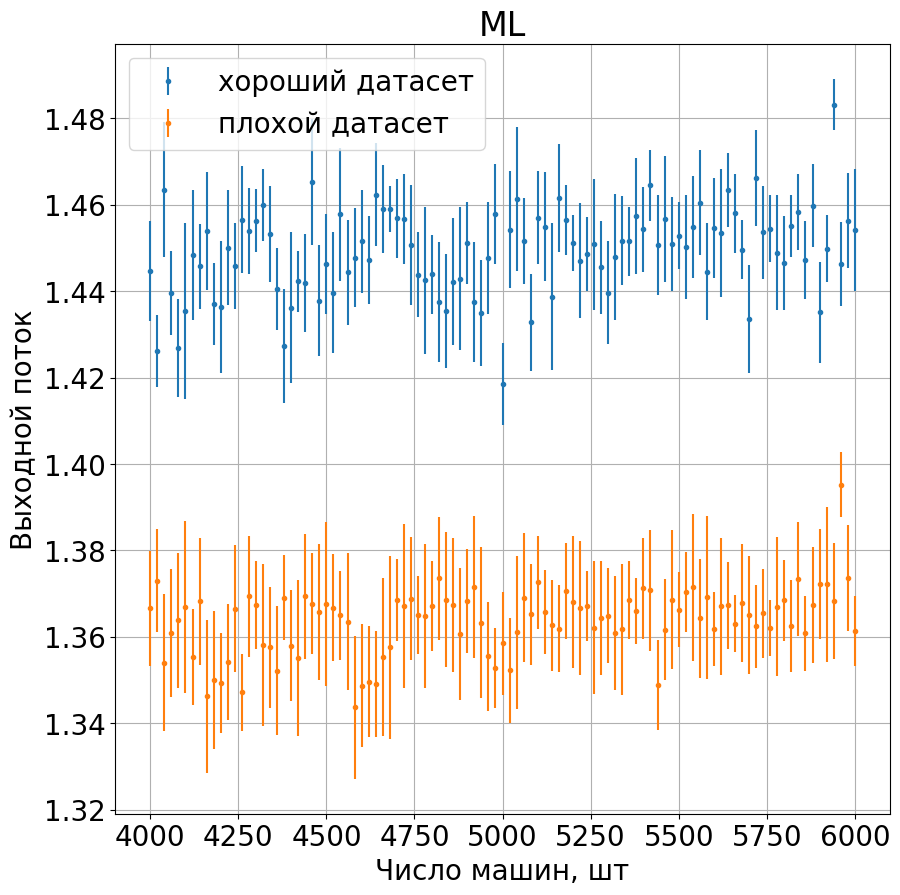

time: 93.4 ms (started: 2024-04-27 04:11:43 +03:00)


In [41]:
bad_data = np.load(bad_res_filename)
good_data = np.load(good_res_filename)

fig, ax = plt.subplots()
ax.set_title("ML")
ax.set_xlabel("Число машин, шт")
ax.set_ylabel("Выходной поток")
ax.errorbar(good_data['N_arr'], good_data['out'][:,0], yerr=good_data['out'][:,1], fmt='.', label='хороший датасет')
ax.errorbar(bad_data['N_arr'], bad_data['out'][:,0], yerr=bad_data['out'][:,1], fmt='.', label='плохой датасет')
# ax.plot(good_data['N_arr'], good_data['out'][:,0], label='хороший датасет')
# ax.plot(bad_data['N_arr'], bad_data['out'][:,0], label='плохой датасет')
ax.grid()
ax.legend()
plt.show()

# DL
Так как наша симуляция считается долго, то было решено написать нейроную сеть, которая будет предсказывать результаты симуляции

In [16]:
datasetName = 'csv_data/test6_without.csv'

nn_model = Throughput_nn()
nn_model.fit(datasetName, n_epochs = 200, test_size = 0.1, nn_seed = 13, split_seed = 13)
nn_model.save('res_data/nn_model.keras')

Epoch 1/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 1621.7716 - val_loss: 0.0362
Epoch 2/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 0.0335 - val_loss: 0.0225
Epoch 3/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 0.0375 - val_loss: 3.6824
Epoch 4/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - loss: 2.0223 - val_loss: 0.1816
Epoch 5/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - loss: 1.9372 - val_loss: 0.1426
Epoch 6/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - loss: 2.0758 - val_loss: 2.0754
Epoch 7/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step - loss: 1.6148 - val_loss: 0.1403
Epoch 8/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - loss: 1.5120 - val_loss: 9.7028
Epoch 9/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - loss: 1.2330 - val_loss: 15.0473
Epoch 10/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - loss: 1.1845 - val_loss: 0.0067
Epoch 11/200
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - loss: 1.2345 - val_loss: 

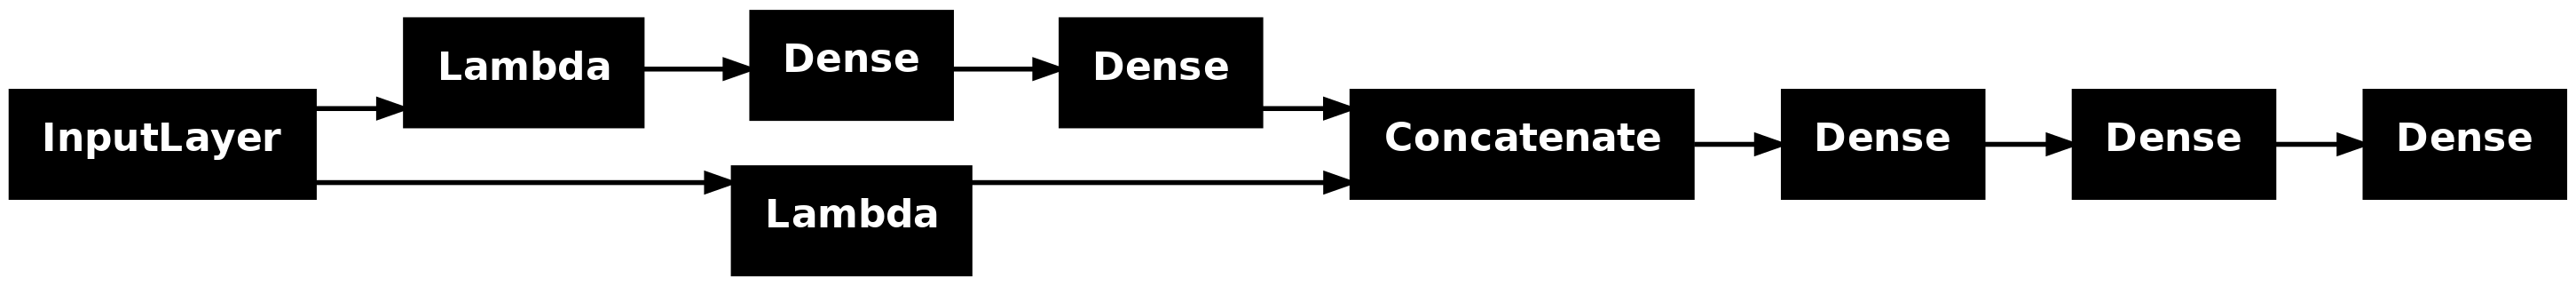

time: 81.6 ms (started: 2024-04-25 22:22:48 +03:00)


In [3]:
from tensorflow.keras.utils import plot_model
plot_model(nn_model.model, rankdir='LR')

далее мы прогоняем полученную нейронную сеть в отжиге

In [25]:
def loss(d, N):
    ans = -nn_model.predict(d0=d[0], d1=d[1], d2=d[2], N=N)
    return ans

time: 309 µs (started: 2024-04-27 03:25:24 +03:00)


In [30]:
# simple optimization

N_arr = np.linspace(4000, 6000, 21)
opt_d = np.zeros((21, 3))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(15, 40), (15, 40), (1.5, 8)], args=[N_arr[n]], maxiter=300)
    ans = sol.x

    opt_d[n, :] = ans
    
    np.savez('res_data/DL_res', opt_d=opt_d, N_arr=N_arr)


100%|██████████| 21/21 [12:51<00:00, 36.74s/it]

time: 12min 51s (started: 2024-04-27 03:31:58 +03:00)


In [31]:
# dots for graph calc
data = np.load('res_data/DL_res.npz')

opt_d = data['opt_d']
N_arr = data['N_arr']

time: 891 µs (started: 2024-04-27 03:44:50 +03:00)


In [32]:
out=np.zeros((N_arr.shape[0], 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], opt_d[n, 0], opt_d[n, 1], opt_d[n, 2])
    
np.savez('res_data/DL_throughput', out=out, N_arr=N_arr)

100%|██████████| 21/21 [00:40<00:00,  1.93s/it]

time: 40.4 s (started: 2024-04-27 03:44:50 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

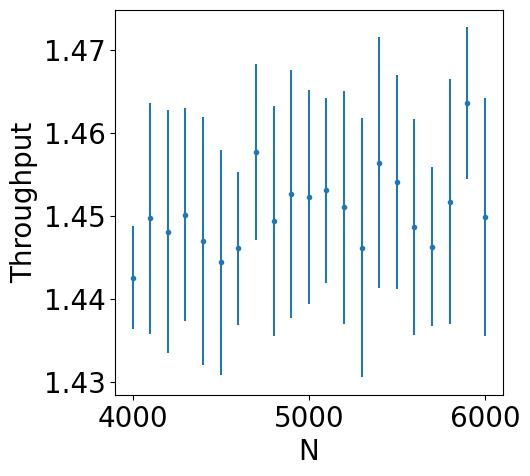

time: 60.1 ms (started: 2024-04-27 04:07:41 +03:00)


In [35]:
data=np.load('res_data/DL_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# Summary

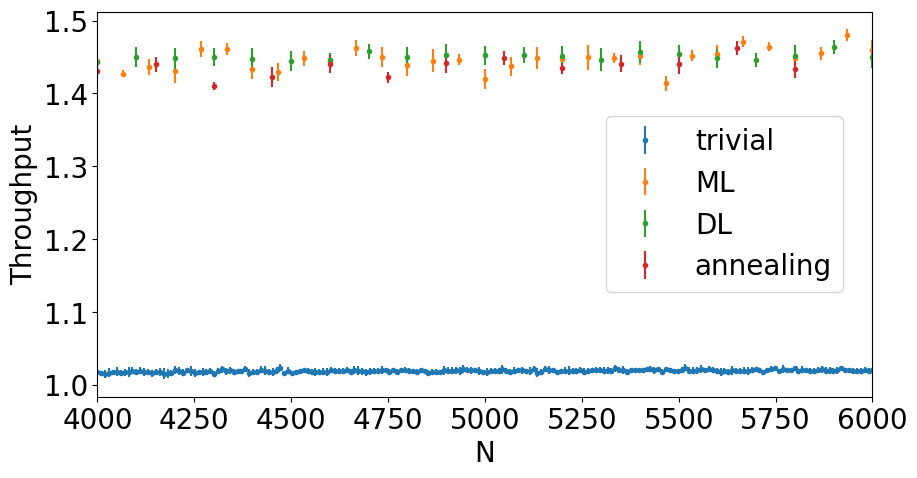

time: 109 ms (started: 2024-04-27 06:40:53 +03:00)


In [140]:
data = np.load('res_data/simple_throughput.npz')
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

fig, ax = plt.subplots()
#ax.set_title("Summary")
plt.xlim([4000, 6000])
plt.rcParams["figure.figsize"] = (10, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label="trivial")

data=np.load('res_data/learn_data/good_ML.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='ML')

data=np.load('res_data/DL_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='DL')

data=np.load('res_data/annealing_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='annealing')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(0.98, 0.5))
plt.show

plt.savefig('graph_data/summary_sq.pdf', bbox_inches='tight')

<function matplotlib.pyplot.show(close=None, block=None)>

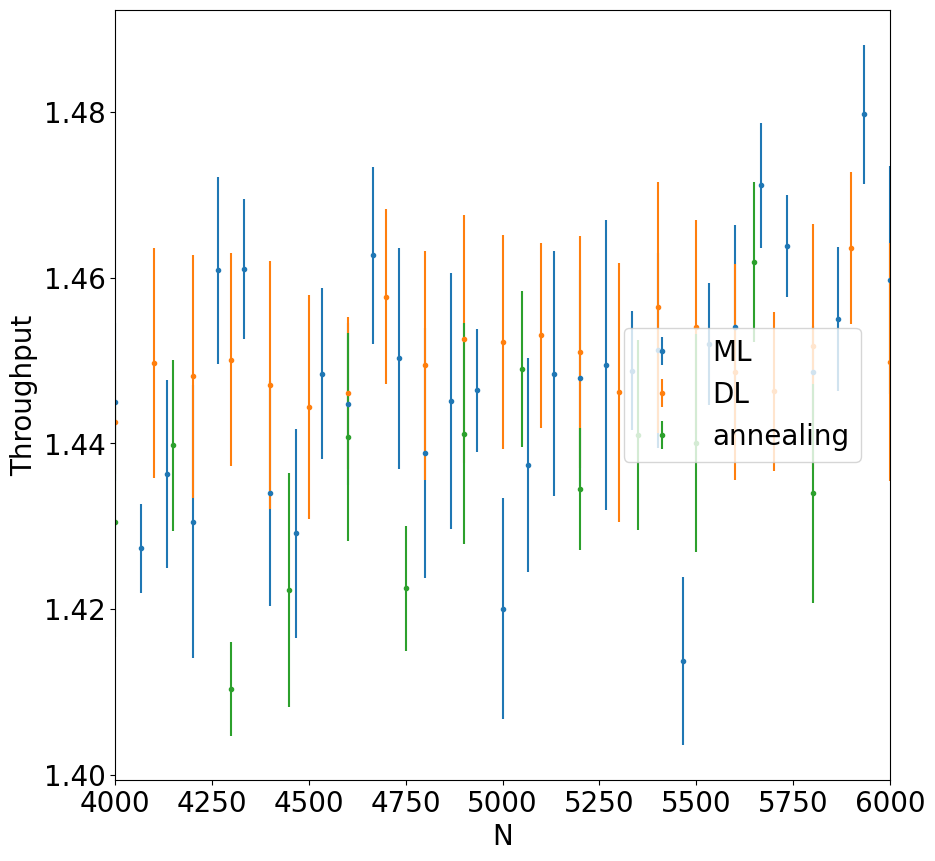

time: 86 ms (started: 2024-04-27 04:18:55 +03:00)


In [53]:
data = np.load('res_data/simple_throughput.npz')
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

fig, ax = plt.subplots()
plt.xlim([4000, 6000])
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

#ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label="trivial")

data=np.load('res_data/learn_data/good_ML.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='ML')

data=np.load('res_data/DL_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='DL')

data=np.load('res_data/annealing_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='annealing')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(0.98, 0.5))
plt.show

In [102]:
# what about trivial optimum interpolation?

# calculation of throughput()
N_arr=np.around(np.linspace(8000, 100, 201))
out=np.zeros((201, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 38.7809173, 34.7588042, 1.52391483)
    
np.savez('res_data/opt_throughput_wide_1', out=out, N_arr=N_arr)

# calculation of throughput()
N_arr=np.around(np.linspace(8000, 101, 203))
out=np.zeros((203, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 50.19090321, 41.99869441,  2.19535969)
    
np.savez('res_data/opt_throughput_wide_2', out=out, N_arr=N_arr)

100%|██████████| 203/203 [05:46<00:00,  1.70s/it]

time: 11min 29s (started: 2024-04-27 04:42:43 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

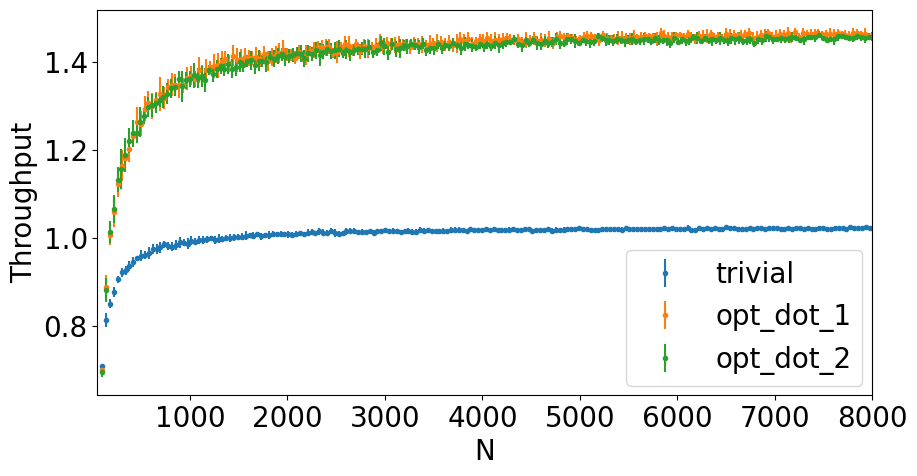

time: 82.3 ms (started: 2024-04-27 04:59:22 +03:00)


In [114]:
fig, ax = plt.subplots()
plt.xlim([50, 8000])
plt.rcParams["figure.figsize"] = (10, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")


data = np.load('res_data/simple_throughput_wide.npz')
ax.errorbar(data['N_arr'][50:250], data['out'][50:250, 0], yerr=np.asarray(data['out'][50:250, 1]), linestyle="", marker=".", label='trivial')

data=np.load('res_data/opt_throughput_wide_1.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='opt_dot_1')

data=np.load('res_data/opt_throughput_wide_2.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='opt_dot_2')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(1.005, 0.2))
plt.show

In [115]:
# what about trivial optimum interpolation?

# calculation of throughput()
N_arr=np.around(np.linspace(100, 1500, 200))
out=np.zeros((200, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 2, 2, 2, default_gap=2)
    
np.savez('res_data/simple_throughput_low', out=out, N_arr=N_arr)

# calculation of throughput()
N_arr=np.around(np.linspace(100, 1500, 201))
out=np.zeros((201, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 38.7809173, 34.7588042, 1.52391483)
    
np.savez('res_data/opt_throughput_low_1', out=out, N_arr=N_arr)

# calculation of throughput()
N_arr=np.around(np.linspace(100, 1500, 203))
out=np.zeros((203, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 50.19090321, 41.99869441,  2.19535969)
    
np.savez('res_data/opt_throughput_low_2', out=out, N_arr=N_arr)

100%|██████████| 203/203 [00:37<00:00,  5.42it/s]

time: 2min 15s (started: 2024-04-27 05:04:22 +03:00)


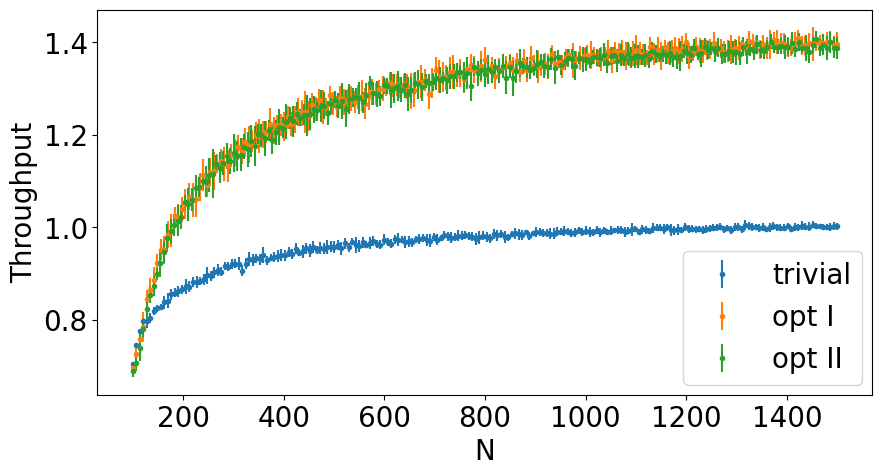

time: 127 ms (started: 2024-04-27 06:36:19 +03:00)


In [138]:
fig, ax = plt.subplots()
#plt.xlim([50, 8000])
plt.rcParams["figure.figsize"] = (10, 5)
#ax.set_title("Wide N")
ax.set_xlabel("N")
ax.set_ylabel("Throughput")


data = np.load('res_data/simple_throughput_low.npz')
ax.errorbar(data['N_arr'][:], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='trivial')

data=np.load('res_data/opt_throughput_low_1.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='opt I')

data=np.load('res_data/opt_throughput_low_2.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='opt II')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(1.005, 0.2))
plt.show

plt.savefig('graph_data/N_wide.pdf', bbox_inches='tight')